In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from fastai.vision.all import *
from torchvision import transforms
import torchvision.transforms.functional as TF
import ipywidgets as widgets
from PIL import Image as pilImage
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import sys
sys.path.append("../") 
%load_ext autoreload
%autoreload 2
from src.utils import *
from src.gradcam import *

In [2]:
ROOT_DIR =  Path('../')
DATA_PATH = ROOT_DIR/'data/'
IMGS_PATH = ROOT_DIR/'imgs/'

In [3]:
path = untar_data(URLs.IMAGENETTE_160,dest=DATA_PATH)
(path/'train').ls()

(#10) [Path('../data/imagenette2-160/train/n03394916'),Path('../data/imagenette2-160/train/n03417042'),Path('../data/imagenette2-160/train/n03445777'),Path('../data/imagenette2-160/train/n02102040'),Path('../data/imagenette2-160/train/n03425413'),Path('../data/imagenette2-160/train/n03888257'),Path('../data/imagenette2-160/train/n03028079'),Path('../data/imagenette2-160/train/n03000684'),Path('../data/imagenette2-160/train/n01440764'),Path('../data/imagenette2-160/train/n02979186')]

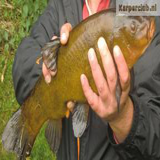

In [4]:
fname = (path/"train/n01440764").ls()[1]
PILImage.create(fname).resize((160,160))

In [5]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
#eval() is very important, otherwise the results are not useable 
#(I don't understand why train mode computes almost always the same results, no matter what's the input img)
model = model.eval() 

Using cache found in /Users/ap/.cache/torch/hub/pytorch_vision_v0.6.0


In [6]:
import urllib.request, json 
with urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json') as url:
    classes = json.loads(url.read().decode())
f_to_idx = {val[0]:idx for idx,val in classes.items()}
my_classes = [f_to_idx[f.name] for f in (path/"train").ls()]


In [7]:
device = 'cpu'
use_cuda = True if device == 'cuda' else False

# I need to pass 2 separate versions of the model because something happens in grad_cam that modifies the model
# todo: find out what modifies the model so use only 1 version of it
# todo: make it possible to use only original model version (above). Note that it seems quite tricky to because the model gets overwritten by the GuidedBackpropReLUModel
grad_cam = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
gb_model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)

grad_cam = GradCam(model=grad_cam, feature_module=grad_cam.layer4, \
                   target_layer_names=["2"], use_cuda=use_cuda)
gb_model = GuidedBackpropReLUModel(model=gb_model, use_cuda=use_cuda)



Using cache found in /Users/ap/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /Users/ap/.cache/torch/hub/pytorch_vision_v0.6.0


In [8]:
def get_heatmap(x, target_index = None):
    mask = grad_cam(x, target_index)
    heatmap = arr_to_img(mask,cmap='inferno')
    #cam = np.float32(img)+np.float32(heatmap)
    return heatmap

def get_gradient_act(x, target_index = None):
    _ = grad_cam(x, target_index) # todo: find out how to get rid of this unnecessary call (if I don't call it the gradients are computed differently, why???)
    gb = gb_model(x, index=target_index)
    gb = gb.transpose((1, 2, 0))
    return deprocess_image(gb)

def find_relevant_input(x, target_index = None):
    # If target_index is None, returns the map for the highest scoring category.
    # Otherwise, targets the requested index.
    mask = grad_cam(x, target_index)
    heatmap = arr_to_img(mask,cmap='inferno')

    gb = gb_model(x, index=target_index)
    gb = gb.transpose((1, 2, 0))
    
    cam_mask = np.stack([mask, mask, mask],2)
    cam_gb = deprocess_image(cam_mask*gb)
    gb = deprocess_image(gb)
    return heatmap, gb, cam_gb


In [9]:
#size= 160
#img = PILImage.create(fname).resize((size,size))
#normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                 std=[0.229, 0.224, 0.225])
#x = normalize(transforms.ToTensor()(img)).unsqueeze(0)
#heatmap, gb, cam_gb = find_relevant_input(x.requires_grad_(True))
#
#fig, ax = plt.subplots(1,4,figsize=(18,6))
#ax[0].imshow(img)
#cam = np.float32(img)+np.float32(heatmap)
#ax[1].imshow(arr_to_img(cam))
#ax[2].imshow(gb)
#ax[3].imshow(cam_gb)
#plt.show()

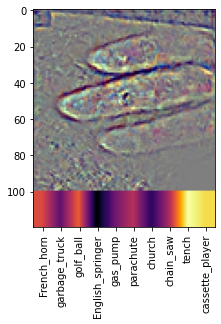

In [57]:
class MyImg():
    def __init__(self,img,model=None,cuda=False,get_model_act=False,restrict_classes=None,normalize=None):
        self.img_orig = img.copy()
        self.img = img.copy()
        self.out_img = img.copy()
        self.x_orig = transforms.ToTensor()(img).unsqueeze(0)
        self.x = transforms.ToTensor()(img).unsqueeze(0)
        self.x = self.x.cuda() if cuda else self.x
        self.model = model.cuda() if cuda else model
        self.get_model_act = get_model_act
        self.images = []
        self.activations = []
        self.restrict_classes = restrict_classes
        self.class_idx = [int(i) for i in restrict_classes.keys()] if restrict_classes is not None else None
        self.normalize = normalize if normalize is not None else lambda x: x
        self.cuda = cuda

    def reset(self):
        self.img = self.img_orig.copy()
        self.x = self.x_orig # does this work without some kind of copy ? in tfms() it seems to work
        self.x = self.x.cuda() if self.cuda else self.x
        self.images = []
        self.activations = []
        
    def tfm_brightness(self, brightness):
        x =  TF.adjust_brightness(self.x, brightness)
        return x
    
    def tfm_centercrop(self, crop_size):
        x =  transforms.CenterCrop(crop_size)(self.x)
        return x  
    
    def tfm_perspective(self, perspective_w=None, perspective_h=None, perspective_d=0):
        width, height = self.x.shape[2:]
        w = perspective_w if perspective_w is not None else width
        h = perspective_h if perspective_h is not None else height
        d = perspective_d
        startpoints = [[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]]
        endpoints = [[0, 0], [w, d], [w, h], [0, h]] 
        return TF.perspective(self.x, startpoints, endpoints, pilImage.BILINEAR)
    
    def tfm_erase(self, erase_i=0, erase_j=0, erase_h=0, erase_w=0):
        return TF.erase(self.x,erase_i,erase_j,erase_h,erase_w,0)
    
    def tfm_rotate(self, angle):
        return TF.rotate(self.x,angle=angle)
    
    def tfms(self, brightness=None, crop_size=None, highlight_act=None, rotate_ang=None, show=True, **args):
        self.x = self.x_orig.cuda() if self.cuda else self.x_orig
        # first run all augmentation methods
        # adjust brightness
        if brightness is not None:
            self.x = self.tfm_brightness(brightness)
        # center crop the image
        if crop_size is not None:
            self.x = self.tfm_centercrop(crop_size)
        # rotate the image
        if rotate_ang is not None:
            self.x = self.tfm_rotate(rotate_ang)
        # perspective distorition    
        perspective_args = {k:v for k,v in args.items() if 'perspective' in k}
        if len(perspective_args):
            self.x = self.tfm_perspective(**perspective_args)
        # erase part of the image    
        erase_args = {k:v for k,v in args.items() if 'erase' in k}
        if len(erase_args):
            self.x = self.tfm_erase(**erase_args)
                
        # then run activation localization
        if (highlight_act is not None) & (highlight_act != 'none'):
            x_input = self.normalize(self.x).requires_grad_(True)
            if highlight_act == 'cam':
                heatmap = get_heatmap(x_input)
                # need to renormalize the image before adding it to another image
                #cam = np.float32(arr_to_img(self.x[0].permute(1,2,0).numpy())) + np.float32(heatmap)
                cam = tensor_to_np_img(min_max_scaler(self.x[0].detach())) + np.float32(heatmap)
                self.out_img = arr_to_img(cam)
            elif highlight_act == 'gradient':
                self.out_img = get_gradient_act(x_input)
            elif highlight_act == 'gradcam':
                heatmap, gb, cam_gb = find_relevant_input(x_input)
                self.out_img = cam_gb
            else:
                assert 0, f'highlight_act "{highlight_act}" not known'
        else:
            self.out_img = transforms.ToPILImage()(self.x[0])
            
        # then add model activation 
        # Note: Here we use a different model as in the activation localization. 
        # todo: use same model and use reuse model output from forward pass above (see also comments when loading the models)   
        if self.get_model_act:
            out = self.model(self.normalize(self.x)).cpu().detach().numpy()
            if self.restrict_classes is not None:
                out = out[:,self.class_idx]
            self.activations.append(out)
            self.out_img = self.combine_activation_with_img(self.out_img, out)
        self.images.append(self.out_img)
        
        if show:
            #display(pilImage.fromarray(img).to_thumb(512,512))
            fig,ax = plt.subplots()
            
            try:
                my_xticks = self.restrict_classes.values()
                nr_classes = len(self.restrict_classes)
                h,w,d = self.out_img.shape
                step_size = w/nr_classes
                #plt.xticks(np.arange(nr_classes)*step_size+(step_size//2), my_xticks,rotation=90)
                ax.set_xticks(np.arange(nr_classes)*step_size+(step_size//2))
                ax.set_xticklabels(my_xticks,rotation=90)
                
            except Exception:
                #print((h,w,d),step_size,(step_size//2,(w-step_size//2+1)))
                #print(np.arange(nr_classes)*step_size+(step_size//2))     
                pass
            ax.imshow(self.out_img)
    
    def combine_activation_with_img(self, img, out):
        # to make flatten activation better visible, the images will be streched by a factor of 20 
        # and the width is adapted to the original image width
        shape = (20,img.shape[1])

        # combine transformed images and their layer activations
        img_comb = np.vstack([img, arr_to_img(imresize(out,shape), 'inferno') ])
        return img_comb
    
    def create_gif(self,path): 
        # to make flatten activation better visible, the images will be streched by a factor of 20 and the width is adapted to the original image width
        w,h,d = self.images[0].shape
        transform_act = lambda x: arr_to_img(imresize(x,(20,w)), 'inferno') 

        # combine sequence of transformed images and their layer activations
        imgs_combs = [ np.vstack([arr_to_img(img).resize((w,h)), transform_act(act) ]) for img, act in zip(self.images,self.activations)  ]

        # transform to images, add backward loop and store as gif
        first_img, *imgs = [ pilImage.fromarray( img ) for img in imgs_combs]
        imgs += [img for img in imgs[::-1]]
        first_img.save(fp=path, format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)

        
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
size = 160
img = PILImage.create(fname).resize((size,size))
myimg = MyImg(img,
              model,
              cuda=False,
              get_model_act=True,
              restrict_classes={i:classes[i][1] for i in my_classes},
              normalize=normalize)
myimg.tfms(crop_size=100,highlight_act='gradcam',perspective_w=180,perspective_h=180,perspective_d=20,erase_w=10,erase_h=10,rotate_ang=90)

In [51]:
#import cProfile
#cProfile.run('myimg.tfms(crop_size=120)',sort='cumtime')

In [44]:
width, height = myimg.img.shape

import ipywidgets as widgets
def create_gif_on_click(change):
    myimg.create_gif(IMGS_PATH/'test2.gif')

btn_create_gif = widgets.Button(description='Create gif')
btn_create_gif.on_click(create_gif_on_click)

btn_act_loc = widgets.RadioButtons(
    options=['none','cam','gradient','gradcam',],
    description='Activation Localization:',
    disabled=False)

sl_brightness = widgets.FloatSlider(value=1,min=0.1,max=4,step=0.2)
box_brightness = widgets.VBox([widgets.HTML('<em>Brightness</em>'),sl_brightness])

sl_crop_size = widgets.IntSlider(value=width,min=33,max=width,step=5)
box_crop = widgets.VBox([widgets.HTML('<em>Center Crop</em>'),sl_crop_size])

sl_rotate = widgets.IntSlider(value=0,min=0,max=360,step=5)
box_rotate = widgets.VBox([widgets.HTML('<em>Rotation Angle</em>'),sl_rotate])
sl_perspective_w = widgets.IntSlider(value=width,min=0,max=width,step=5)
sl_perspective_h = widgets.IntSlider(value=height,min=0,max=height,step=5)
sl_perspective_d = widgets.IntSlider(value=0,min=0,max=height,step=5)
box_perspective = widgets.VBox([widgets.HTML('<em>Perspective Distortion</em>'),sl_perspective_w,sl_perspective_h,sl_perspective_d])

sl_erase_i = widgets.IntSlider(value=0,min=0,max=width,step=5)
sl_erase_j = widgets.IntSlider(value=0,min=0,max=height,step=5)
sl_erase_w = widgets.IntSlider(value=0,min=0,max=height,step=5)
sl_erase_h = widgets.IntSlider(value=0,min=0,max=height,step=5)
box_erase = widgets.VBox([widgets.HTML('<em>Erase Box</em>'),sl_erase_i,sl_erase_j,sl_erase_w, sl_erase_h])

out_tfms = widgets.interactive_output(myimg.tfms, {"brightness":sl_brightness,"crop_size":sl_crop_size,"highlight_act":btn_act_loc, "rotate_ang":sl_rotate,
                                                  "perspective_w":sl_perspective_w,"perspective_h":sl_perspective_h,"perspective_d":sl_perspective_d,
                                                  "erase_i":sl_erase_i,"erase_j":sl_erase_j,"erase_w":sl_erase_w, "erase_h":sl_erase_h})

In [46]:
myimg.reset()
#out_tfms.clear_output()
widgets.HBox([widgets.VBox([box_brightness, box_crop, box_rotate, box_perspective, box_erase,
                            btn_act_loc, btn_create_gif]), out_tfms])

[SegmentLocal](../imgs/test2.gif "segment")


[SegmentLocal](../imgs/test.gif "segment")
[SegmentLocal](../imgs/results/test.gif "segment")


In [38]:
# to save the images separate 
#os.makedirs('../imgs/img_list/',exist_ok=True)
#os.makedirs('../imgs/results/',exist_ok=True)
#
#for i,pic in enumerate(imgs):
#    pic.save(fp=f'../imgs/img_list/img_{str(i).zfill(2)}.png', format='PNG')

# to use ffmpeg I need to deactivate conda and call this in the terminal
# but it doesn't seem for me that the results are better, so I leave it for now
#ffmpeg -f image2 -i imgs/img_list/img_%02d.png -vf scale=2480:-1:sws_dither=ed,palettegen imgs/results/palette.png -y
#ffmpeg -f image2 -framerate 10. -i imgs/img_list/img_%02d.png imgs/results/img.flv -y
#ffmpeg -i imgs/results/img.flv -i imgs/results/palette.png -filter_complex "fps=10,scale=248:-1:flags=lanczos[x];[x][1:v]paletteuse" imgs/results/test.gif -y
#ffmpeg -i imgs/results/img.flv -i imgs/results/palette.png -filter_complex "fps=10,scale=248:-1:flags=lanczos[x];[x][1:v]paletteuse" -loop -1 imgs/results/test_no_loop.gif -y
